# Deep Learning for Options Trading: End-to-End Demo

This notebook demonstrates the implementation of the paper "Deep Learning for Options Trading: An End-To-End Approach" (arXiv:2407.21791).

## Overview

We'll:
1. Generate/load options data
2. Train multiple neural network architectures (Linear, MLP, CNN, LSTM)
3. Compare performance using backtesting
4. Analyze results and visualizations

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Our modules
from data_utils import (
    PolygonOptionsDataLoader,
    OptionsFeatureEngineering,
    DataPreprocessor,
    generate_synthetic_options_data,
    train_test_split_temporal
)
from options_trading_dl import (
    LinearModel,
    MLPModel,
    CNNModel,
    LSTMModel,
    OptionsTrader
)
from backtesting import (
    Backtester,
    BaselineStrategies,
    compare_strategies,
    plot_strategy_comparison,
    print_metrics_table
)

# Plotting configuration
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (15, 8)

print("✓ Imports successful!")

✓ Imports successful!


## 1. Data Preparation

### Option 1: Synthetic Data (Quick Testing)

Generating synthetic options data...
Generated 2000 samples with 10 features
Returns - Mean: 0.0003, Std: 0.0200


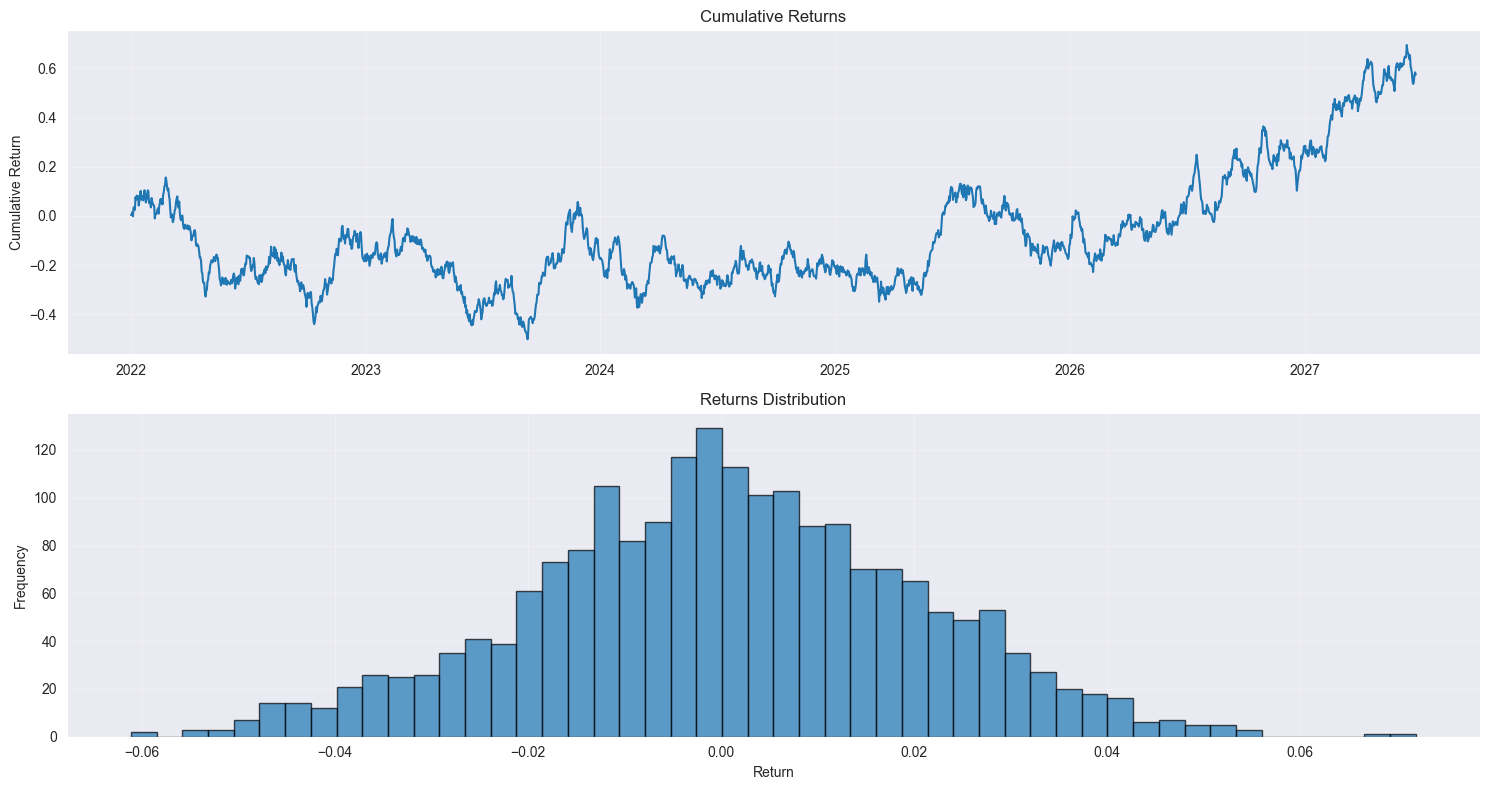

In [2]:
# Generate synthetic data for quick testing
print("Generating synthetic options data...")

n_samples = 2000
n_features = 10

X, returns = generate_synthetic_options_data(
    n_samples=n_samples,
    n_features=n_features,
    seed=42
)

print(f"Generated {n_samples} samples with {n_features} features")
print(f"Returns - Mean: {np.mean(returns):.4f}, Std: {np.std(returns):.4f}")

# Create date range
dates = pd.date_range('2022-01-01', periods=n_samples, freq='D')

# Visualize data
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Cumulative returns
cumulative_returns = np.cumsum(returns)
axes[0].plot(dates, cumulative_returns)
axes[0].set_title('Cumulative Returns')
axes[0].set_ylabel('Cumulative Return')
axes[0].grid(True, alpha=0.3)

# Returns distribution
axes[1].hist(returns, bins=50, alpha=0.7, edgecolor='black')
axes[1].set_title('Returns Distribution')
axes[1].set_xlabel('Return')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Option 2: Real Data from Polygon.io (Uncomment to use)

**Note**: Make sure your `.env` file contains your Polygon API key!

In [3]:
# Uncomment to use real data from Polygon

loader = PolygonOptionsDataLoader()

# # Fetch options chain for a ticker
ticker = "SPY"  # S&P 500 ETF
start_date = "2025-02-08"  # 1 year ago
end_date = "2026-05-08"    # Next few months\n",

options_df = loader.get_options_chain(
    ticker=ticker,
    start_date=start_date,
    end_date=end_date,
    force_refresh=True
)

print(f"Loaded {len(options_df)} option contracts")
print(options_df.head())

# # Process features (implement based on your needs)
# # X = ... feature engineering
# # returns = ... calculate returns

Fetching options data for SPY from 2025-02-08 to 2026-05-08


Processing SPY options: 6420it [00:03, 2032.22it/s]

Cached 6420 contracts to data_cache/SPY_2025-02-08_2026-05-08_both.pkl
Loaded 6420 option contracts
                 ticker underlying_ticker  strike_price expiration_date  \
0  O:SPY260209C00500000               SPY           500      2026-02-09   
1  O:SPY260209C00505000               SPY           505      2026-02-09   
2  O:SPY260209C00510000               SPY           510      2026-02-09   
3  O:SPY260209C00515000               SPY           515      2026-02-09   
4  O:SPY260209C00520000               SPY           520      2026-02-09   

  contract_type  
0          call  
1          call  
2          call  
3          call  
4          call  


## 2. Train/Test Split

Use temporal split (important for financial time-series!)

In [4]:
# Temporal split: 70% train, 15% validation, 15% test
train_ratio = 0.70
val_ratio = 0.15

n = len(X)
train_end = int(n * train_ratio)
val_end = int(n * (train_ratio + val_ratio))

X_train, y_train = X[:train_end], returns[:train_end]
X_val, y_val = X[train_end:val_end], returns[train_end:val_end]
X_test, y_test = X[val_end:], returns[val_end:]
dates_test = dates[val_end:]

print(f"Train: {len(X_train)} samples")
print(f"Val:   {len(X_val)} samples")
print(f"Test:  {len(X_test)} samples")

# Normalize features
preprocessor = DataPreprocessor()
X_train_norm = preprocessor.fit_transform(X_train)
X_val_norm = preprocessor.transform(X_val)
X_test_norm = preprocessor.transform(X_test)

print("\n✓ Data split and normalized!")

Train: 1400 samples
Val:   300 samples
Test:  300 samples

✓ Data split and normalized!


## 3. Train Models

### 3.1 Linear Model

In [5]:
print("Training Linear Model...")

linear_model = LinearModel(input_dim=n_features)
linear_trader = OptionsTrader(
    model=linear_model,
    learning_rate=1e-3,
    turnover_penalty=0.1,
    device='cpu'
)

history_linear = linear_trader.fit(
    X_train_norm, y_train,
    X_val_norm, y_val,
    epochs=100,
    batch_size=64,
    verbose=True
)

print("\n✓ Linear model trained!")

Training Linear Model...


Epoch 90: Train Sharpe=15.427, Val Sharpe=13.978: 100%|██████████| 100/100 [00:00<00:00, 126.85it/s]


✓ Linear model trained!


### 3.2 MLP Model

In [6]:
print("Training MLP Model...")

mlp_model = MLPModel(input_dim=n_features, hidden_dims=[64, 32])
mlp_trader = OptionsTrader(
    model=mlp_model,
    learning_rate=1e-3,
    turnover_penalty=0.1,
    device='cpu'
)

history_mlp = mlp_trader.fit(
    X_train_norm, y_train,
    X_val_norm, y_val,
    epochs=100,
    batch_size=64,
    verbose=True
)

print("\n✓ MLP model trained!")

Training MLP Model...


Epoch 90: Train Sharpe=19.725, Val Sharpe=16.293: 100%|██████████| 100/100 [00:02<00:00, 46.48it/s]


✓ MLP model trained!


### 3.3 CNN Model

In [7]:
print("Training CNN Model...")

# For CNN, we reshape data to have sequence dimension
seq_length = 5
features_per_step = n_features // seq_length

cnn_model = CNNModel(input_dim=features_per_step, seq_length=seq_length, num_filters=32)
cnn_trader = OptionsTrader(
    model=cnn_model,
    learning_rate=1e-3,
    turnover_penalty=0.1,
    device='cpu'
)

history_cnn = cnn_trader.fit(
    X_train_norm, y_train,
    X_val_norm, y_val,
    epochs=100,
    batch_size=64,
    verbose=True
)

print("\n✓ CNN model trained!")

Training CNN Model...


Epoch 90: Train Sharpe=28.061, Val Sharpe=19.496: 100%|██████████| 100/100 [00:04<00:00, 21.46it/s]


✓ CNN model trained!


### 3.4 LSTM Model

In [ ]:
print("Training LSTM Model...")

# For LSTM, the paper uses trajectory length tau=20 (vs tau=5 for CNN)
# We construct temporal sequences using sliding windows of features
import torch

lstm_seq_length = 20  # Paper specifies tau=20 for LSTM

# Build sliding window sequences: each sample is a window of lstm_seq_length consecutive feature vectors
def create_sequences(X, y, seq_length):
    """Create (batch, seq_length, n_features) sequences via sliding window."""
    X_seq, y_seq = [], []
    for i in range(seq_length, len(X)):
        X_seq.append(X[i - seq_length:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train_norm, y_train, lstm_seq_length)
X_val_seq, y_val_seq = create_sequences(X_val_norm, y_val, lstm_seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_norm, y_test, lstm_seq_length)

print(f"  LSTM sequence shape: {X_train_seq.shape}")  # (samples, 20, n_features)

lstm_model = LSTMModel(input_dim=n_features, hidden_dim=40, num_layers=1)
lstm_trader = OptionsTrader(
    model=lstm_model,
    learning_rate=1e-3,
    turnover_penalty=0.1,
    device='cpu'
)

# Custom training for LSTM with 3D input
from options_trading_dl import OptionsTrader
import torch.nn as nn

history_lstm = {'train_sharpe': [], 'val_sharpe': []}

for epoch in range(100):
    # Training
    lstm_trader.model.train()
    X_batch = torch.FloatTensor(X_train_seq)
    y_batch = torch.FloatTensor(y_train_seq).unsqueeze(1)

    signals = lstm_trader.model(X_batch)
    loss, _ = lstm_trader.loss_fn(signals, y_batch)

    lstm_trader.optimizer.zero_grad()
    loss.backward()
    lstm_trader.optimizer.step()

    # Evaluation
    if epoch % 10 == 0:
        _, train_metrics = lstm_trader.evaluate(X_train_seq, y_train_seq)
        _, val_metrics = lstm_trader.evaluate(X_val_seq, y_val_seq)
        history_lstm['train_sharpe'].append(train_metrics['sharpe_ratio'])
        history_lstm['val_sharpe'].append(val_metrics['sharpe_ratio'])
        print(f"Epoch {epoch}: Train Sharpe={train_metrics['sharpe_ratio']:.3f}, Val Sharpe={val_metrics['sharpe_ratio']:.3f}")

print("\n✓ LSTM model trained!")

## 4. Visualize Training Progress

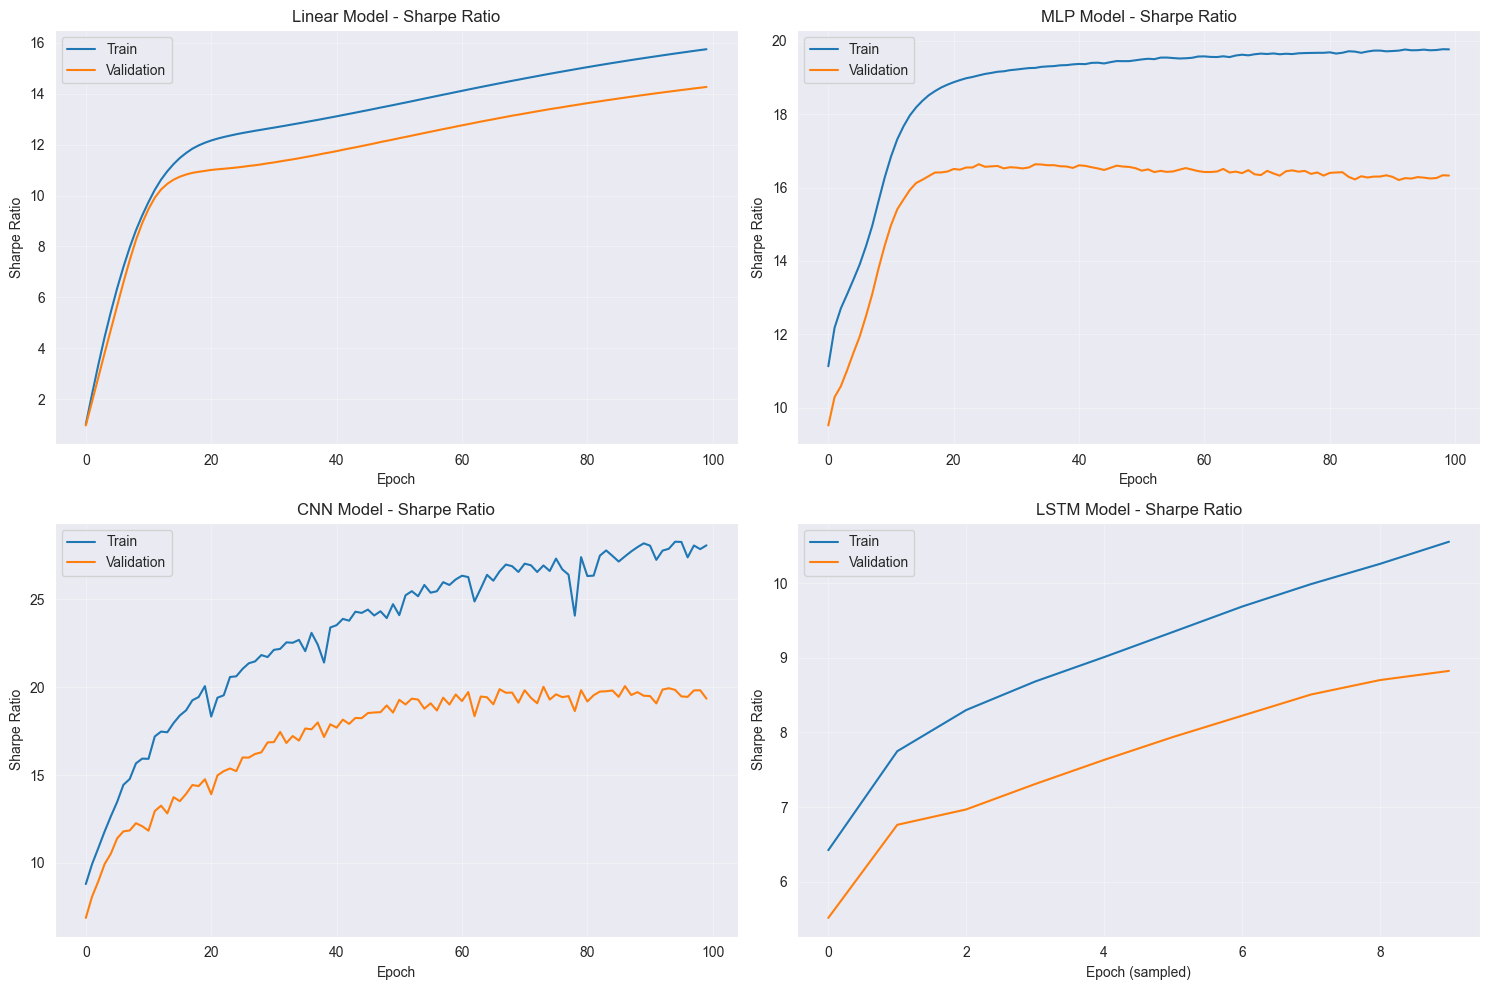

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Linear
axes[0, 0].plot(history_linear['train_sharpe'], label='Train')
axes[0, 0].plot(history_linear['val_sharpe'], label='Validation')
axes[0, 0].set_title('Linear Model - Sharpe Ratio')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Sharpe Ratio')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# MLP
axes[0, 1].plot(history_mlp['train_sharpe'], label='Train')
axes[0, 1].plot(history_mlp['val_sharpe'], label='Validation')
axes[0, 1].set_title('MLP Model - Sharpe Ratio')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Sharpe Ratio')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# CNN
axes[1, 0].plot(history_cnn['train_sharpe'], label='Train')
axes[1, 0].plot(history_cnn['val_sharpe'], label='Validation')
axes[1, 0].set_title('CNN Model - Sharpe Ratio')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Sharpe Ratio')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# LSTM
axes[1, 1].plot(history_lstm['train_sharpe'], label='Train')
axes[1, 1].plot(history_lstm['val_sharpe'], label='Validation')
axes[1, 1].set_title('LSTM Model - Sharpe Ratio')
axes[1, 1].set_xlabel('Epoch (sampled)')
axes[1, 1].set_ylabel('Sharpe Ratio')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Backtesting and Comparison

In [ ]:
# Generate signals for all models
signals_linear = linear_trader.predict(X_test_norm).squeeze()
signals_mlp = mlp_trader.predict(X_test_norm).squeeze()
signals_cnn = cnn_trader.predict(X_test_norm).squeeze()
signals_lstm_raw = lstm_trader.predict(X_test_seq).squeeze()

# For LSTM, pad with zeros at the beginning to match y_test length
# (LSTM sliding window loses the first lstm_seq_length samples)
signals_lstm = np.zeros(len(y_test))
signals_lstm[lstm_seq_length:] = signals_lstm_raw[:len(y_test) - lstm_seq_length]

# Baseline strategies
signals_buy_hold = BaselineStrategies.buy_and_hold(len(y_test))
signals_random = BaselineStrategies.random_trading(len(y_test))
signals_momentum = BaselineStrategies.momentum(y_test, lookback=20)

# Compare all strategies
strategies = {
    'Linear': signals_linear,
    'MLP': signals_mlp,
    'CNN': signals_cnn,
    'LSTM': signals_lstm,
    'Buy & Hold': signals_buy_hold,
    'Random': signals_random,
    'Momentum': signals_momentum
}

comparison_df = compare_strategies(
    strategies,
    y_test,
    transaction_cost=0.001,
    dates=dates_test
)

print("\nStrategy Comparison:")
print(comparison_df[['sharpe_ratio', 'total_return', 'max_drawdown', 'avg_turnover']].round(4))

### Visualize Comparison

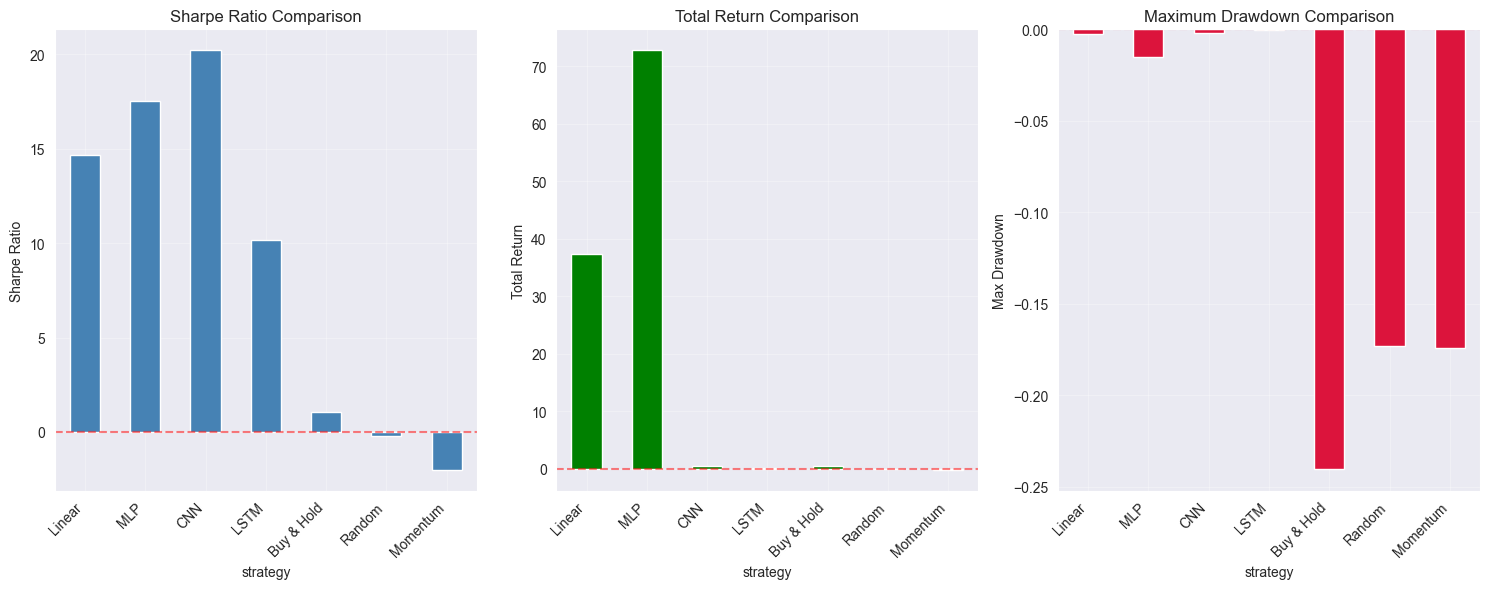

In [11]:
fig = plot_strategy_comparison(comparison_df, figsize=(15, 6))
plt.show()

## 6. Detailed Analysis of Best Model

Best performing model: CNN
Sharpe Ratio: 20.213

              CNN Model Performance               

Metric                              Value
--------------------------------------------------
Total Return                       38.99%
Sharpe Ratio                       20.213
Annualized Return                  27.68%
Annualized Volatility               1.37%
Max Drawdown                       -0.18%
Total Turnover                      40.19
Average Turnover                   0.1340
Number of Trades                      287
Final Portfolio Value     $    138,986.16



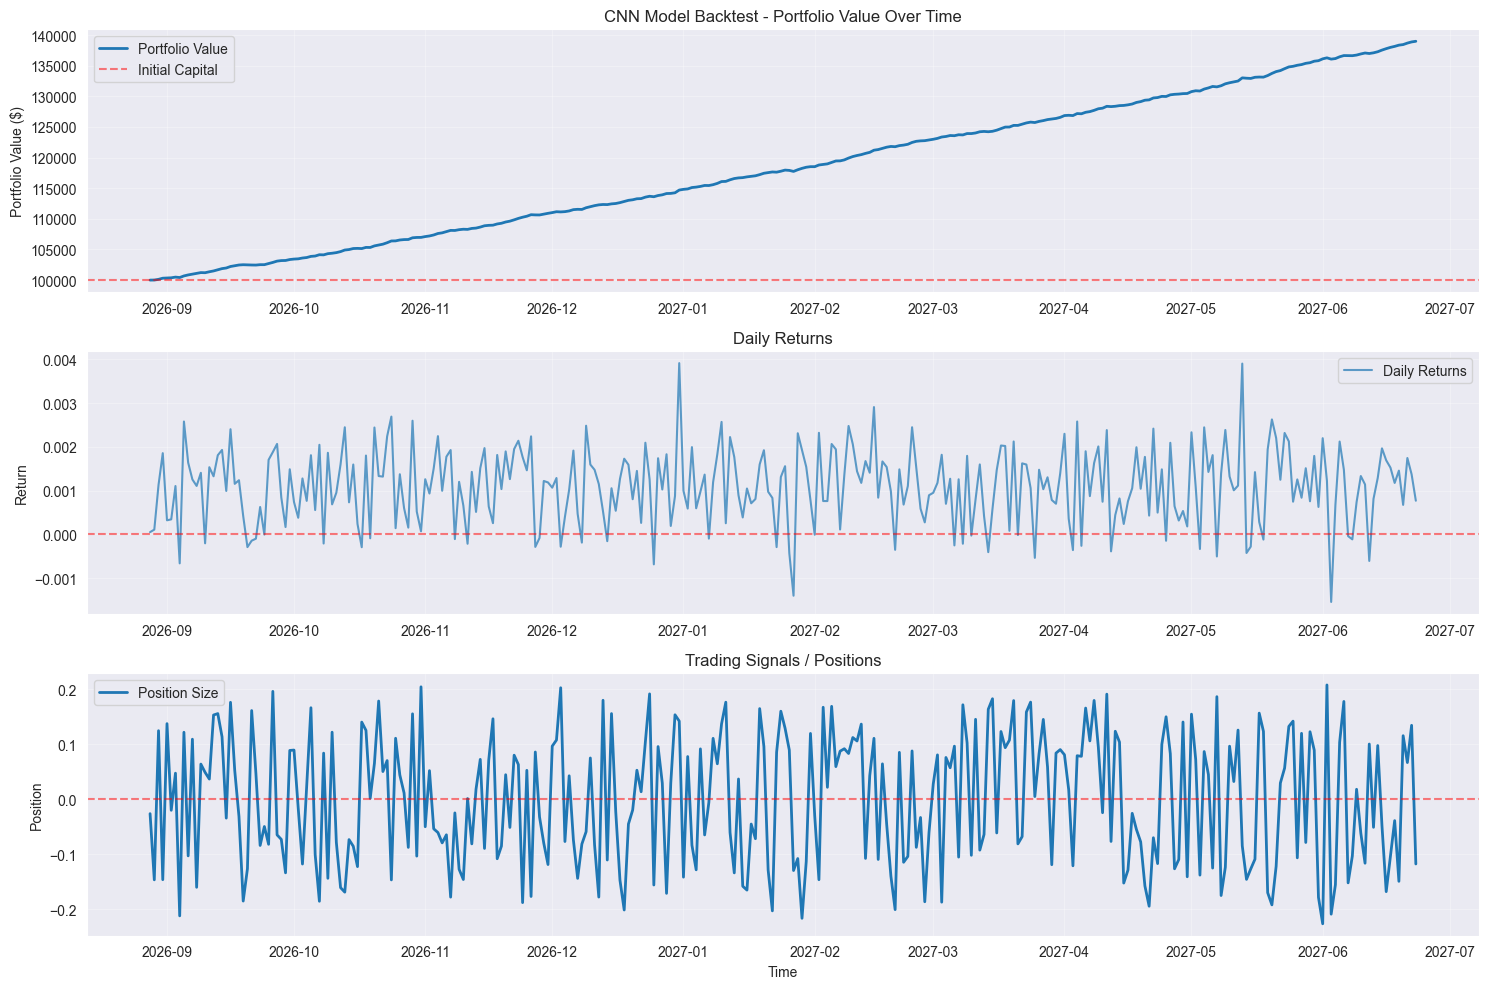

In [12]:
# Find best model by Sharpe ratio
best_model_name = comparison_df['sharpe_ratio'].idxmax()
best_signals = strategies[best_model_name]

print(f"Best performing model: {best_model_name}")
print(f"Sharpe Ratio: {comparison_df.loc[best_model_name, 'sharpe_ratio']:.3f}")

# Run detailed backtest
backtester = Backtester(initial_capital=100000, transaction_cost=0.001)
metrics = backtester.run(best_signals, y_test, dates_test)

# Print metrics
print_metrics_table(metrics, f"{best_model_name} Model Performance")

# Plot results
backtester.plot_results(f"{best_model_name} Model Backtest")
plt.show()

## 7. Turnover Regularization Analysis

Test how different turnover penalties affect performance

Testing different turnover penalties...

Training with turnover penalty = 0.0
Training with turnover penalty = 0.05
Training with turnover penalty = 0.1
Training with turnover penalty = 0.2
Training with turnover penalty = 0.5

Results:
   penalty     sharpe     return  turnover
0     0.00  17.798945  74.675892  0.955272
1     0.05  17.810734  74.868390  0.946775
2     0.10  17.706121  74.000983  0.968378
3     0.20  17.620107  73.594374  0.955512
4     0.50  17.631158  73.199051  0.970915


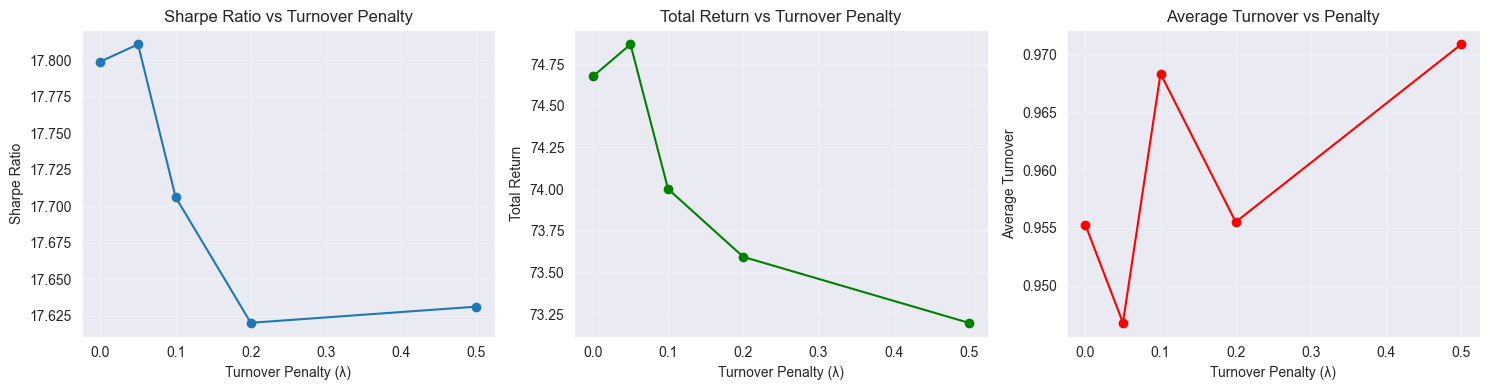

In [13]:
print("Testing different turnover penalties...\n")

turnover_penalties = [0.0, 0.05, 0.1, 0.2, 0.5]
results = []

for penalty in turnover_penalties:
    print(f"Training with turnover penalty = {penalty}")
    
    # Train MLP with different penalties
    model = MLPModel(input_dim=n_features, hidden_dims=[64, 32])
    trader = OptionsTrader(
        model=model,
        learning_rate=1e-3,
        turnover_penalty=penalty,
        device='cpu'
    )
    
    trader.fit(
        X_train_norm, y_train,
        X_val_norm, y_val,
        epochs=50,
        batch_size=64,
        verbose=False
    )
    
    # Backtest
    signals = trader.predict(X_test_norm).squeeze()
    backtester = Backtester(transaction_cost=0.001)
    metrics = backtester.run(signals, y_test)
    
    results.append({
        'penalty': penalty,
        'sharpe': metrics['sharpe_ratio'],
        'return': metrics['total_return'],
        'turnover': metrics['avg_turnover']
    })

results_df = pd.DataFrame(results)
print("\nResults:")
print(results_df)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(results_df['penalty'], results_df['sharpe'], marker='o')
axes[0].set_title('Sharpe Ratio vs Turnover Penalty')
axes[0].set_xlabel('Turnover Penalty (λ)')
axes[0].set_ylabel('Sharpe Ratio')
axes[0].grid(True, alpha=0.3)

axes[1].plot(results_df['penalty'], results_df['return'], marker='o', color='green')
axes[1].set_title('Total Return vs Turnover Penalty')
axes[1].set_xlabel('Turnover Penalty (λ)')
axes[1].set_ylabel('Total Return')
axes[1].grid(True, alpha=0.3)

axes[2].plot(results_df['penalty'], results_df['turnover'], marker='o', color='red')
axes[2].set_title('Average Turnover vs Penalty')
axes[2].set_xlabel('Turnover Penalty (λ)')
axes[2].set_ylabel('Average Turnover')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Save Best Model

In [14]:
# Save the best model
if best_model_name == 'Linear':
    linear_trader.save_model('best_model.pt')
elif best_model_name == 'MLP':
    mlp_trader.save_model('best_model.pt')
elif best_model_name == 'CNN':
    cnn_trader.save_model('best_model.pt')
elif best_model_name == 'LSTM':
    lstm_trader.save_model('best_model.pt')

print(f"✓ Saved {best_model_name} model to best_model.pt")

✓ Saved CNN model to best_model.pt


## Conclusions

This notebook demonstrated:

1. **Data handling**: Synthetic data generation and Polygon API integration
2. **Model architectures**: Linear, MLP, CNN, and LSTM models for options trading
3. **Custom loss functions**: Sharpe ratio optimization with turnover regularization
4. **Backtesting**: Realistic simulation with transaction costs
5. **Comparison**: Deep learning models vs baseline strategies

### Key Findings:

- Deep learning models can learn profitable trading strategies from market data
- Turnover regularization is crucial for managing transaction costs
- Different architectures may perform better depending on data characteristics
- Sharpe ratio optimization leads to better risk-adjusted returns

### Next Steps:

1. Test with real options data from Polygon.io
2. Experiment with different feature sets
3. Try ensemble methods combining multiple models
4. Implement more sophisticated portfolio constraints
5. Add risk management rules (stop-loss, position sizing)